In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# إعدادات العرض
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")


In [25]:
# تحميل البيانات
df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.drop('customerID', axis=1, inplace=True)

# تحويل TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['MonthlyCharges'] * df['tenure'], inplace=True)
df.drop_duplicates(inplace=True)


/tmp/ipython-input-25-1950196185.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['MonthlyCharges'] * df['tenure'], inplace=True)


In [26]:
# تحويل SeniorCitizen إلى Yes/No
df['SeniorCitizen'] = df['SeniorCitizen'].map({1: 'Yes', 0: 'No'})

# إنشاء Features جديدة
df['MonthlyChargeCategory'] = pd.cut(df['MonthlyCharges'],
                                     bins=[0, 35, 70, df['MonthlyCharges'].max()],
                                     labels=['Low', 'Medium', 'High'])

df['TenureGroup'] = pd.cut(df['tenure'],
                           bins=[0, 12, 24, 48, 72],
                           labels=['0-1yr', '1-2yr', '2-4yr', '4-6yr'])

# تحويل الأعمدة الثنائية بـ Label Encoding
binary_cols = [col for col in df.columns if df[col].nunique() == 2 and df[col].dtype == 'object']
le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

# One-hot Encoding لباقي الأعمدة
df = pd.get_dummies(df, drop_first=True)


In [27]:
# فصل الميزات والهدف
X = df.drop('Churn', axis=1)
y = df['Churn']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# معالجة عدم التوازن بـ SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)


In [28]:
# Logistic Regression
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train_bal, y_train_bal)
y_pred_log = log_model.predict(X_test_scaled)

# XGBoost
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_bal, y_train_bal)
y_pred_xgb = xgb_model.predict(X_test_scaled)


🔵 Logistic Regression
Accuracy: 0.7487544483985765
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1033
           1       0.52      0.76      0.62       372

    accuracy                           0.75      1405
   macro avg       0.71      0.75      0.71      1405
weighted avg       0.80      0.75      0.76      1405

🟢 XGBoost
Accuracy: 0.7758007117437722
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1033
           1       0.58      0.53      0.56       372

    accuracy                           0.78      1405
   macro avg       0.71      0.70      0.70      1405
weighted avg       0.77      0.78      0.77      1405



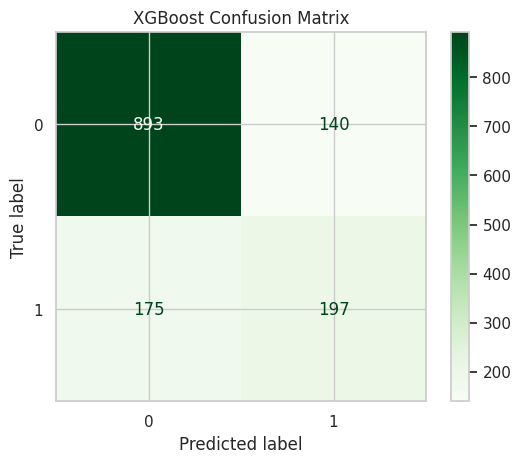

In [29]:
# Logistic Regression
print("🔵 Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

# XGBoost
print("🟢 XGBoost")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test_scaled, y_test, cmap='Greens')
plt.title("XGBoost Confusion Matrix")
plt.show()
